In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


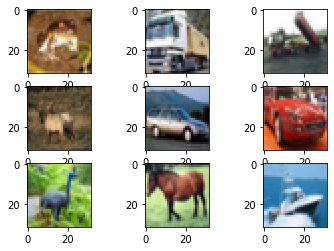

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [3]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

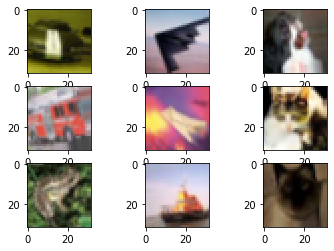

In [4]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [5]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [7]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [8]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

In [11]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 493s 10ms/step - loss: 1.4645 - accuracy: 0.5185 - val_loss: 1.2308 - val_accuracy: 0.5638
Epoch 2/10
50000/50000 [==============================] - 382s 8ms/step - loss: 0.8683 - accuracy: 0.6956 - val_loss: 0.8012 - val_accuracy: 0.7188
Epoch 3/10
50000/50000 [==============================] - 273s 5ms/step - loss: 0.6805 - accuracy: 0.7632 - val_loss: 0.7630 - val_accuracy: 0.7431
Epoch 4/10
50000/50000 [==============================] - 277s 6ms/step - loss: 0.5651 - accuracy: 0.8054 - val_loss: 0.7170 - val_accuracy: 0.7557
Epoch 5/10
50000/50000 [==============================] - 270s 5ms/step - loss: 0.4776 - accuracy: 0.8329 - val_loss: 0.6806 - val_accuracy: 0.7723
Epoch 6/10
50000/50000 [==============================] - 268s 5ms/step - loss: 0.4009 - accuracy: 0.8596 - val_loss: 0.6961 - val_accuracy: 0.7810
Epoch 7/10
50000/50000 [==============================] - 271

In [12]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

50000/50000 [==============================] - 88s 2ms/step


[0.11474992364883423, 0.9617800116539001]

In [15]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')
#build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [16]:
# train with image augmentation
history2=model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/390 [==============================] - 271s 694ms/step - loss: 1.6225 - accuracy: 0.4629 - val_loss: 1.1684 - val_accuracy: 0.5770
Epoch 2/10
391/390 [==============================] - 271s 694ms/step - loss: 1.0576 - accuracy: 0.6276 - val_loss: 0.9862 - val_accuracy: 0.6803
Epoch 3/10
391/390 [==============================] - 272s 695ms/step - loss: 0.8732 - accuracy: 0.6918 - val_loss: 0.8354 - val_accuracy: 0.7190
Epoch 4/10
391/390 [==============================] - 276s 706ms/step - loss: 0.7823 - accuracy: 0.7266 - val_loss: 0.7106 - val_accuracy: 0.7612
Epoch 5/10
391/390 [==============================] - 271s 693ms/step - loss: 0.7141 - accuracy: 0.7516 - val_loss: 0.6668 - val_accuracy: 0.7770
Epoch 6/10
391/390 [==============================] - 273s 699ms/step - loss: 0.6593 - accuracy: 0.7704 - val_loss: 0.6954 - val_accuracy: 0.7700
Epoch 7/10
391/390 [==============================] - 274s 700ms/step - loss: 0.6103 - accuracy: 0.7888 - val_loss: 0.5945 -

In [18]:
#model2.save('cifar10_02.h5')         
#90.26, (128 batch, 0.001 lr, 512 neurons, no zoom, no convdrop, only 0.1 shift) 

In [20]:
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

10000/10000 [==============================] - 18s 2ms/step


[0.5563096184253693, 0.8141999840736389]

In [21]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

50000/50000 [==============================] - 89s 2ms/step


[0.448003672618866, 0.8465399742126465]